## Problema

El problema consiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago
de Chile (SCL). Para eso les entregamos un dataset usando datos públicos y reales donde cada fila corresponde a un vuelo
que aterrizó o despegó de SCL. Para cada vuelo se cuenta con la siguiente información:

* **Fecha-I** : Fecha y hora programada del vuelo.
* **Vlo-I** : Número de vuelo programado.
* **Ori-I** : Código de ciudad de origen programado.
* **Des-I** : Código de ciudad de destino programado.
* **Emp-I** : Código aerolínea de vuelo programado.
* **Fecha-O** : Fecha y hora de operación del vuelo.
* **Vlo-O** : Número de vuelo de operación del vuelo.
* **Ori-O** : Código de ciudad de origen de operación
* **Des-O** : Código de ciudad de destino de operación.
* **Emp-O** : Código aerolínea de vuelo operado.
* **DIA** : Día del mes de operación del vuelo.
* **MES** : Número de mes de operación del vuelo.
* **AÑO** : Año de operación del vuelo.
* **DIANOM** : Día de la semana de operación del vuelo.
* **TIPOVUELO** : Tipo de vuelo, I =Internacional, N =Nacional.
* **OPERA** : Nombre de aerolínea que opera.
* **SIGLAORI** : Nombre ciudad origen.
* **SIGLADES** : Nombre ciudad destino.

## 1. Cargar Librerías

In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
from datetime import datetime


### package importing: 
from flightPredictor.dataHandler import splitter,  transformations
from flightPredictor.models import modelFactory as mf
from geopy.geocoders import Nominatim 
import missingno as msng
import matplotlib.pyplot as plt

## Configuraciones

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
TEST_SIZE = 0.2
VAL_SIZE = 0.2
SPLITTER = splitter.dataSplitter(test_size=TEST_SIZE, val_size=VAL_SIZE)
CLASSIFIER_FACTORY = mf.ModelFactory()
PIPELINE_FACTORY = transformations.pipeGenerator()
# geolocator variable that lets us find the longitude and latitude:
GEOLOCATOR = Nominatim(user_agent="EDA")


## 2. Definición de Columnas Basales

In [3]:
BASE_COLUMNS = ["OPERA", "TIPOVUELO", "MES"]
model_dictionary = {}

<!-- ## 4. Cargar datos -->

## 3. Cargar datos

In [4]:
# IMPORTAMOS LOS DATOS DE LA BASE DE DATOS ORIGINAL
df_real = pd.read_csv("Datasets/dataset_SCL.csv", low_memory=False)
# IMPORTAMOS LAS FEATURES SINTETICAS
df_synthetic = pd.read_csv("Datasets/synthetic_features.csv", low_memory=False)
# UNIMOS AMBOS DATAFRAMES
df = pd.concat([df_real, df_synthetic], axis=1)
# LOS MOSTRMOS:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,temporada_alta,dif_min,atraso_15,periodo_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,noche
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0,0,noche
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0,0,noche
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.0,0,noche
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.0,0,noche


# Corregir Tipo Dato: 


# Revisando y eliminando features: 
En primera instancia, veamos la distribución que tiene la variable año en los datos

In [5]:
df["AÑO"].value_counts()

2017    68204
2018        2
Name: AÑO, dtype: int64

Como se puede ver solamente existen dos fechas que tienen por año 2018. Esto significa que para el modelo a generar estas variables son irrelevantes. 

Sumado a esto, las variables Fecha-O y dif_min son variables que no pueden ser entregadas al modelo porque se usan para generar las features de 15_atraso. Además, notemos que cualquier modelo que busquemos utilizar a futuro no puede tener esta información ya que tiene que partir el vuelo para poder saberlo, por lo que estas features también deben ser eliminadas. 

Veamos como distribuyen las variables Vlo-O, VLo-I: 

In [6]:
vlo_o_count = df["Vlo-O"].value_counts()
vlo_i_count = df["Vlo-I"].value_counts()

print(f"Vlo-O tiene {len(vlo_o_count)} valores diferentes \nVlo-I tiene {len(vlo_i_count)} valroes diferentes\n de los cuales {len(set(vlo_o_count).intersection(set(vlo_i_count)))} son iguales")

Vlo-O tiene 861 valores diferentes 
Vlo-I tiene 584 valroes diferentes
 de los cuales 154 son iguales


Como podemos ver los valores de los vuelos tienen cerca de 600 valores diferentes, haciendo que sea una variable muy dispersa en el dataset, esto hará que no sea una buena variable para considerar y por ende también debe ser eliminada de los datos. 

<Figure size 500x600 with 0 Axes>

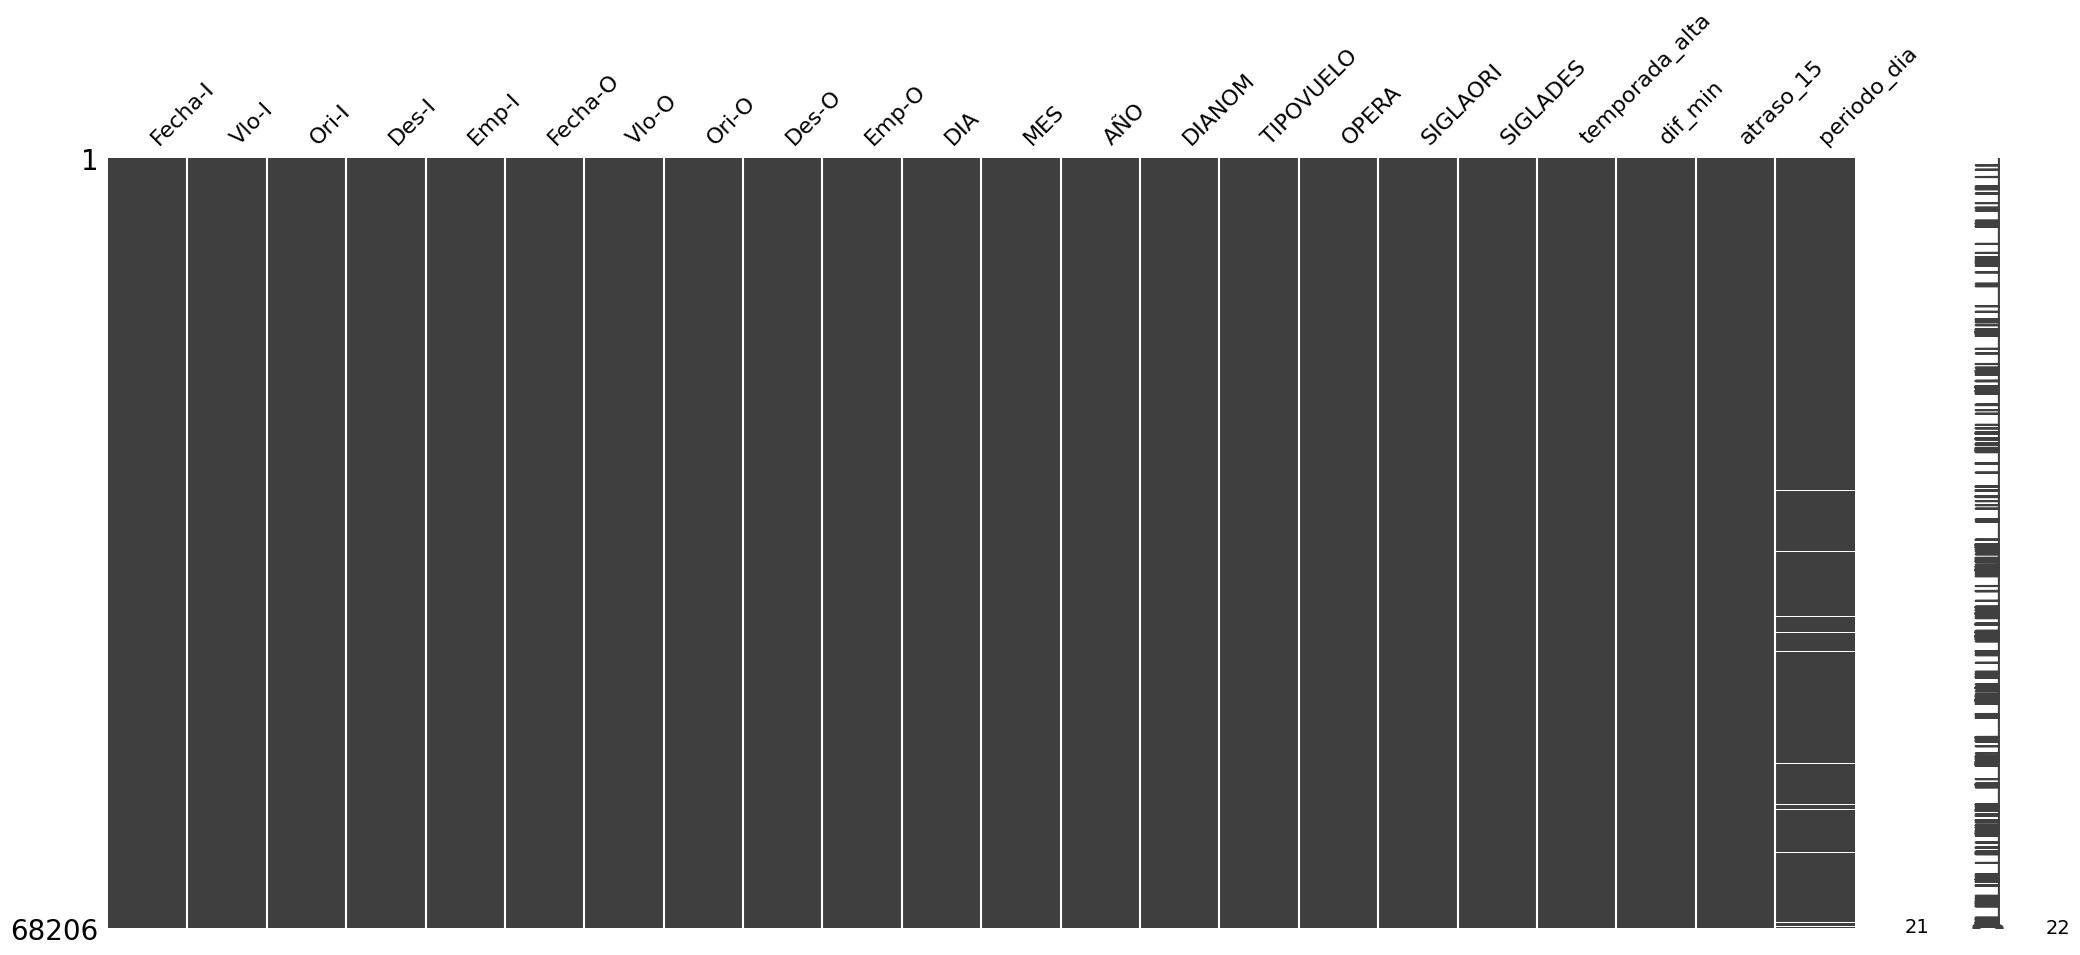

In [7]:
plt.figure(figsize=(5, 6))

# Generate the missingness matrix plot
msng.matrix(df)

# Show the plot
plt.show()

Notemos que el periodo del día tiene un error en su definición, esto ya que tiene cerca de 2000 valores que son nulos. Veamos que sucedió: 

Notemos que todas las horas que generan este problema son horas que se encuentren con horarios cerrados. Al ver el modelo de Juan, podemos notar que no considera los casos donde las horas son cerradas, por ejemplo las 500 de la mañana. Volveremos a definir al variable, pero esta vez considerando estos casos bordes.

In [8]:
df[df["periodo_dia"].isnull()].head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,temporada_alta,dif_min,atraso_15,periodo_dia
652,2017-01-09 05:00:00,4495,SCEL,MPTO,CMP,2017-01-09 05:15:00,4495,SCEL,MPTO,CMP,...,2017,Lunes,I,Copa Air,Santiago,Ciudad de Panama,1,15.0,0,NaN
1040,2017-01-02 19:00:00,8075,SCEL,SBGL,TAM,2017-01-02 19:17:00,8075,SCEL,SBGL,TAM,...,2017,Lunes,I,Grupo LATAM,Santiago,Rio de Janeiro,1,17.0,1,NaN
1680,2017-01-05 12:00:00,108,SCEL,SCSE,SKU,2017-01-05 12:02:00,108,SCEL,SCSE,SKU,...,2017,Jueves,N,Sky Airline,Santiago,La Serena,1,2.0,0,NaN
1684,2017-01-12 12:00:00,108,SCEL,SCSE,SKU,2017-01-12 12:02:00,108,SCEL,SCSE,SKU,...,2017,Jueves,N,Sky Airline,Santiago,La Serena,1,2.0,0,NaN
1688,2017-01-19 12:00:00,108,SCEL,SCSE,SKU,2017-01-19 11:57:00,108,SCEL,SCSE,SKU,...,2017,Jueves,N,Sky Airline,Santiago,La Serena,1,-3.0,0,NaN


In [9]:
def get_periodo_dia(fecha):
    fecha_time = datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S').time()
    mañana_min = datetime.strptime("05:00", '%H:%M').time()
    mañana_max = datetime.strptime("11:59", '%H:%M').time()
    tarde_min = datetime.strptime("12:00", '%H:%M').time()
    tarde_max = datetime.strptime("18:59", '%H:%M').time()
    noche_min1 = datetime.strptime("19:00", '%H:%M').time()
    noche_max1 = datetime.strptime("23:59", '%H:%M').time()
    noche_min2 = datetime.strptime("00:00", '%H:%M').time()
    noche_max2 = datetime.strptime("4:59", '%H:%M').time()
    
    if(fecha_time >= mañana_min and fecha_time <= mañana_max):
        return 'mañana'
    elif(fecha_time >= tarde_min and fecha_time <= tarde_max):
        return 'tarde'
    elif((fecha_time >= noche_min1 and fecha_time <= noche_max1) or
         (fecha_time >= noche_min2 and fecha_time <= noche_max2)):
        return 'noche'

In [10]:
df['periodo_dia'] = df['Fecha-I'].apply(get_periodo_dia)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Fecha-I         68206 non-null  object 
 1   Vlo-I           68206 non-null  object 
 2   Ori-I           68206 non-null  object 
 3   Des-I           68206 non-null  object 
 4   Emp-I           68206 non-null  object 
 5   Fecha-O         68206 non-null  object 
 6   Vlo-O           68205 non-null  object 
 7   Ori-O           68206 non-null  object 
 8   Des-O           68206 non-null  object 
 9   Emp-O           68206 non-null  object 
 10  DIA             68206 non-null  int64  
 11  MES             68206 non-null  int64  
 12  AÑO             68206 non-null  int64  
 13  DIANOM          68206 non-null  object 
 14  TIPOVUELO       68206 non-null  object 
 15  OPERA           68206 non-null  object 
 16  SIGLAORI        68206 non-null  object 
 17  SIGLADES        68206 non-null 

Podemos ver que solucionamos el problema del periodo del día, también podemos notar que Vlo_O tiene un valor nulo en una de sus filas, esto a priori no genera problema ya que no es una variable que estemos pensando utilizar para la predicción. por lo que ahora pasaremos a transformar las columnas en sus tipos, por ejemplo la Fecha-I la pasaremos a tipo dataframe para poder utilizar los beneficios de este tipo de objetos.

In [12]:
df["Fecha-I"] = pd.to_datetime(df["Fecha-I"],  format='%Y-%m-%d %H:%M:%S')

Eliminaremos las columnas que dijimos que no eran de utilidad

In [13]:
df.drop(columns= ["AÑO","Fecha-O", "dif_min", "Vlo-O", "Vlo-I"], inplace=True)

Evitaremos tener datos de tipo object ya que así no tendremos problemas con los métodos de resampling: Para esto utilizaremos el pipeline generado el cual no permitirá hacer un encoding ordinal de los datos que sean de tipo categórico. El resto de esos valores será excluido de manera de no realizarles ninguna clase de codificación. Notemos que como el pipeline no les hace nada a los datos entregados que no estén en el diccionario de codificación, estos tenemos que pasarlos al final del dataframe para evitar cambios en los datos. 

In [14]:
exclude = ["atraso_15", "DIA", "MES", "temporada_alta", "Fecha-I"]
features_to_encode = [a_column  for a_column in df.columns if not a_column in exclude]
column_to_turn_categorical = {"ordinal":features_to_encode}
categorical_pipeline = PIPELINE_FACTORY.generate_pipeline(column_to_turn_categorical)

In [15]:
df = df[features_to_encode+exclude]

### Transformamos los datos

In [16]:
df_encoded = pd.DataFrame(categorical_pipeline.fit_transform(df), columns=df.columns)

In [17]:
df_encoded["HOUR-I"] = df.apply(lambda x: 100*x["Fecha-I"].hour+x["Fecha-I"].minute, axis=1)

In [18]:
df_encoded.head()

,Ori-I,Des-I,Emp-I,Ori-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,periodo_dia,atraso_15,DIA,MES,temporada_alta,Fecha-I,HOUR-I
0,0.0,9.0,0.0,0.0,10.0,2.0,0.0,0.0,5.0,0.0,34.0,1.0,0,1,1,1,2017-01-01 23:30:00,2330
1,0.0,9.0,0.0,0.0,10.0,2.0,2.0,0.0,5.0,0.0,34.0,1.0,0,2,1,1,2017-01-02 23:30:00,2330
2,0.0,9.0,0.0,0.0,10.0,2.0,3.0,0.0,5.0,0.0,34.0,1.0,0,3,1,1,2017-01-03 23:30:00,2330
3,0.0,9.0,0.0,0.0,10.0,2.0,4.0,0.0,5.0,0.0,34.0,1.0,0,4,1,1,2017-01-04 23:30:00,2330
4,0.0,9.0,0.0,0.0,10.0,2.0,1.0,0.0,5.0,0.0,34.0,1.0,0,5,1,1,2017-01-05 23:30:00,2330


# 4.1 Pregunta 1:
Escoge el modelo que a tu criterio tenga un mejor performance, argumentando tu decisión.


**Respuesta:** 
La pregunta sobre que modelo es mejor, tiene directa relación con el problema a resolver. Como se indica en el enunciado del Jupyter notebook de Juan, el problema definido es el de predecir el retraso de aviones. De esta manera, a la hora de saber que modelo es mejor es necesario comparar la métrica que mejor represente el comportamiento que queremos del modelo. De este modo, a continuación y a modo de resumen adjunto los resultados obtenidos por los modelos entrenados en el notebook de Juan. 

### Modelo de Regresión Logística: 
|   | precision | recall | f1-score | support |
|---|-----------|--------|----------|---------|
| 0 | 0.82      | 1      | 0.9      | 18403   |
| 1 | 0.57      | 0.03   | 0.06     | 4105    |
### Modelo XGBoost
|   | precision | recall | f1-score | support |
|---|-----------|--------|----------|---------|
| 0 | 0.82      | 1      | 0.9      | 18403   |
| 1 | 0.67      | 0.02   | 0.04     | 4105    |
### Modelo XGBoost con mejores Features:
|   | precision | recall | f1-score | support |
|---|-----------|--------|----------|---------|
| 0 | 0.82      | 1      | 0.9      | 18403   |
| 1 | 0.66      | 0.01   | 0.03     | 4105    |
### Modelo XGBoost con upsampled data 
|   | precision | recall | f1-score | support |
|---|-----------|--------|----------|---------|
| 0 | 0.68      | 0.93   | 0.79     | 18403   |
| 1 | 0.62      | 0.19   | 0.3      | 9897    |

La predicción de retrasos en aviones para las aerolines tiene beneficios no solamente para los pasajeros, sino que para la aerolínea también. Desde un punto de vista puramente de costos operacionales según <a href=https://www.airlines.org/dataset/u-s-passenger-carrier-delay-costs>Airlines for America</a> el costo por minuto de "Block time" ronda los $80 dólares (cifras 2021), este tiempo considera el minuto desde que el avión cierra sus puertas hasta el instante en que este llega a la compuerta en su destino. Considerando lo anterior un avión que sufra retrasos tendrá un costo tanto por su tiempo de vuelo como además el tiempo que utilice para llegar a la compuerta. 

Además del costo anterior, existe un costo económico que debe ser considerado, ya que según <a href=https://www.sernac.cl/portal/607/w3-article-5594.html>Sernac</a> los pasajeros que sufran por retrasos en sus vuelos tienen, en algunos casos, derecho a una indemnización. Esto sumado a la entrega de una mala experiencia para los usuarios que es fundamental para cualquier aerolínes, ya que parte importante de la competencia existente entre ellas es tanto el precio como la experiencia de viaje que puedan proporcionarle al usuario. 

Debido a esto, al momento de desarrollar un modelo que realice predicciones sobre el retraso de los vuelos de aviones, la consideración más importante es la cantidad de vuelos que efectivamente llegaron tarde y fueron seleccionados por el modelo. Tener seguridad de que el modelo presentado tiene una alta taza de recall sobre la clase de retraso es importante ya que permite que la aerolínea al saber sobre dicho retraso pueda tomar acción desde el punto de vista de la gestión de tanto el vuelo como del pasajero, además es importante que la tasa de precisión no sea baja ya que también es importante que la detección de atrasos no tenga falsos positivos.  

De este modo, si se consideran los modelos entrenados en el notebook de Juan, se podrá ver que el modelo de recall con upsampling tiene el mayor recall de todos, pero al momento de hacer dicho aumento de muestras dicho aumento fue realizado también sobre la clase de prueba, por lo que los resultados encontrados en esa corrida del algoritmo están sesgados a que la distribución de clases presentes en los datos de testeo no son los originales. Debido a esto es necesario correr nuevamente dicho algoritmo.

## 5. Muestra original de los  datos

### 5.1 Modelo Basal

<ol>
  <p>Para este modelo las columnas que se utilizarán serán las mismas utilizadas en el notebook anterior. Dichas columnas son las siguientes: </p>
  <li>OPERA</li>
  <li>TIPOVUELO</li>
  <li>MES</li>
</ol>

Un punto importante a considerar en el notebook, es que al momento de extraer los datos se utilizan las siguientes columnas:
'OPERA', 'MES', 'TIPOVUELO', 'SIGLADES', 'DIANOM', 'atraso_15'

Pero al momento de generar los datos para entrenar los modelos no son utilizadas todas las columnas. Por esto, el modelo que se genera solamente trabajará con: 'OPERA', 'MES', 'TIPOVUELO'. Lo anterior se hace para poder entrenar el modelo basal. 

A continuación, se muestra la linea de la celda textual (sección 4.) que genera los datos para los modelos de predicción:

features = pd.concat([pd.get_dummies(data['OPERA'], prefix = 'OPERA'),pd.get_dummies(data['TIPOVUELO'], prefix = 'TIPOVUELO'), pd.get_dummies(data['MES'], prefix = 'MES')], axis = 1)





In [19]:
# generando datos iniciales
X = df_encoded[BASE_COLUMNS]
# obteniendo los targets
Y = df_encoded["atraso_15"].astype(bool)

In [20]:
# usar el modelo de split para generar el diccionario de splitting que buscamos
split_dict = SPLITTER.split(X, Y)

### Distribución de los datos:

In [21]:
print(f"Cantidad de vuelos {Y.count()}",f"Cantidad de atrasos {Y.sum()}", f"Porcentaje de vuelos atrasados en dataset:{Y.sum()/Y.count()}")
SPLITTER.show_split(split_dict)

Cantidad de vuelos 68206 Cantidad de atrasos 12614 Porcentaje de vuelos atrasados en dataset:0.18493974137172683
Cantidad de vuelos train 43651 Cantidad de atrasos 8149 Porcentaje de vuelos atrasados en dataset:0.18668529930585784
Cantidad de vuelos validación 10913 Cantidad de atrasos 2029 Porcentaje de vuelos atrasados en dataset:0.18592504352606984
Cantidad de vuelos test 13642 Cantidad de atrasos 2436 Porcentaje de vuelos atrasados en dataset:0.17856619264037532


Podemos ver como la distribución de los conjuntos es prácticamente la misma, por lo que el modelo al entrenar en estos conjuntos debiese encontrarse con distribuciones parecidas en los datos y no afectadas. 

## 5.1.2Pregunta 2: 
Implementa mejoras sobre el modelo escogiendo la o las técnicas que prefieras

### Respuesta: 
Para mejorar el modelo es necesario considerar en primera instancia que clase de modelo estamos generando y si dicho modelo es el correcto para resolver el problema, además de estos es necesario considerar las funciones objetivo que dicho modelo utiliza para asegurarnos que estas funciones objetivo generan el efecto que se está buscando en este proyecto.
De esta manera, se puede descartar que el error de dicha implementación sea el uso de XGBoost, que es de los mejores modelos utilizados en la página kaggle, en específico en una gran cantidad de problemas de clasificación tanto multiclase como binario. De esta manera, aunque el tipo de modelo que se está utilizando no debe ser el problema talvés la manera en que se está inicializando y evaluando dicho modelo puede tener cierto espacio de mejora. 

Una de las primeras mejoras propuestas es el uso de un conjunto de validación que le permita al algoritmo ajustarse adecuadamente a la distribución real de los datos. Dicho conjunto de validación no se verá afectado por el efecto del cambio de distribución de los datos, permitiendo de este modo que el modelo sea fidedigno con la distribución original. Además, se define que la métrica a utilizar es el AUCPR (Área bajo la curva de Precisión-recall) los modelos que se evalúan con las curvas ROC sobre conjuntos de datos desbalanceados, tienden a sufrir de sobre ajusta con la clase mayoritaria, ya que las curvas roc contemplan en su cálculo la tasa de Verdaderos Negativos, que en caso de conjuntos de datos desbalanceados puede ser muy alta. Las curvas Precisión-recall por el otro lado no tienen esta dependencia y por ende no tienen dicho problema. 

Otra mejora que se implementará será cambiar el tipo de codificación de los datos de one hot encoding a un encoding ordinario, la razón de dicho cambio se debe al algoritmo que se está utilizando, como los algoritmos con árboles de decisión hacen particiones sobre los features, es más fácil para dicho algoritmo separar menos features en comparación a más. 

De esta manera, para generar mejoras sobre el modelo, en primera instancia se obtendrán los datos generados en el jupyter notebook de Juan y se correrá el modelo con dichos datos, de esta manera, los pasos con los que se intentará mejorar dicho modelo son los siguientes: 
<ol>
  <p>Con los features obtenidos por Juan:</p>
  <li>Se correrá el modelo basal con los datos entregados para tener un punto de comparación</li>
  <li>Se correrá el modelo con una mayor taza de oversampling</li>
  <li>Se realizará oversampling utilizando métodos más complejos de oversampling como es SMOTE</li>
  <li>Se realizará oversampling con SMOTE y random undersampling (siendo este la manera recomendada de corre dicho algoritmo)</li>
  
  <p>Uso de otros features:</p>
  <li>Se Utilizarán más features para así enriquecer el modelo generado</li>
  <li>Se obtendrán resultados con los mismos métodos de over y under sampling anteriormente mencionados</li>
   <p>Paso final:</p>
  <li>Grid Search sobre los parámetros del modelo</li>
</ol>

En cada una de las dos etapas propuestas se generará un conjunto de test el cual viene directamente de los datos muestreados y no presenta modificaciones con respecto a las proporciones originales que presenta dicho dataset. 

# Recreación del modelo: 
Para facilitar la creación de modelos creamos dentro del paquete flightPredictions un archivo llamado modelFactory, este modelo permite la generación de clasificadores, entregando el nombre del clasificador y luego sus argumentos para crearlo. En este caso crearemos un modelo de XGBoost. 

In [51]:
model_xgb_base = CLASSIFIER_FACTORY.build_model("xgboost", objective= 'binary:logistic', learning_rate=0.1,n_estimators= 100, subsample= 0.5, eval_metric='aucpr')

Para el entrenamiento del modelo es necesario indicarle como trataremos las columnas del dataset, en este caso es importante notar que no le hemos hecho ningún tipo de preprocesamiento. Solamente es necesario considerar que valores nulos no entren al modelo. De este modo, para entrenar dicha estructura se debe entregar un diccionario de codificación, dicho diccionario permite que el modelo genere los pipelines necesarios para trabajar con los datos. De este modo, los tipos de encoders que se encuentran disponibles son los siguientes: 
1. ordinal: encoder para features categóricas, las transforma en números.
2. one-hot: encoder para variables categóricas, transforma dichas columnas en representaciones binarias. 
3. scale: encoder que permite que escalar los features. 
4. cyclic-hour: representación mediante senos y cosenos que permite mostrar la relación cíclica que existe entre las horas por ejemplo las 23:59 y las 00:00
5. cyclic-month: representación también mediante senos y consenos que permite mostrar la relación cíclica que existe entre los meses por ejemplo: Enero y Diciembre. 

De este modo, podemos ver que se pudo regenerar los resultados obtenidos por Juan. A para poder seleccionar el mejor modelo se procederá a guardar los resultados y así una vez que se corra todo el notebook poder elegir el mejor modelo. La metrica que utilizaremos será el average_precision_score de sklearn el cual calcula el área de la curva precision-recall, esta permite explicar de manera correcta los resultados obtenidos ya que es una métrica que al no considerar los verdaderos negativos, nos permite ajustar los resultados justamente a la clase buscada. 

In [52]:
encoding_dict = {"one-hot": ["OPERA", "TIPOVUELO", "MES"]}
model_xgb_base.fit(split_dict, encoding_dict)

In [53]:
x_test, y_test = split_dict["test"]
predicted_xgb = model_xgb_base.predict(x_test)
print(classification_report(y_test, predicted_xgb))

              precision    recall  f1-score   support

       False       0.83      1.00      0.90     11206
        True       0.67      0.05      0.09      2436

    accuracy                           0.83     13642
   macro avg       0.75      0.52      0.49     13642
weighted avg       0.80      0.83      0.76     13642



In [54]:
model_dictionary["modelxgb_base"]= average_precision_score(y_test, predicted_xgb)


## 6. Oversampling SMOTE

<a href=https://arxiv.org/pdf/1106.1813.pdf>SMOTE</a> (Synthetic Minority Over-Sampling Technique) es un paper publicado el año 2002 en la revista Journal of Artificial Intelligence Research, el método propuesto se plantea como una opción para el método de undersampling o oversampling que se utiliza en muchos casos en la práctica cuando se tienen clases desbalanceadas. En específico, lo que hace este método es generar datos sintéticos de la clase minoritaria para así generar un oversampling de esta, en específico, el método genera muestras utilizando los k-vecinos más cercanos y realizando una perturbación de los features de la muestra en la dirección de dicho vecino. 

El método al hacer esta generación de datos sintéticos en la dirección de uno de sus vecinos más cercanos lo que hace es forzar la generalización de la zona de decisión de la clase minoritaria. Como hiper parpametro este algoritmo utiliza el porcentaje de oversampling que se desea realizar de esta. Además, en este trabajo utilizan una mezcla entre primero hacer uso del algoritmo SMOTE y luego realizar un undersampling sobre la clase mayoritaria. Para intentar mejorar dicho modelo haremos los dos métodos y veremos cual es mejor. 

### 6.1 SMOTE OverSample:
Para este caso se partirá realizando solamente un oversampling de la clase minoritaria, en específico, se buscará que dicha clase represente aproximadamente el 70% de los datos de la clase mayoritaria. Actualmente los datos de la clase **retraso** representan aproximadamente el 18% de la base de datos. Esto implica que realizaremos un aumento de 166% de los datos, esto con el fin de verificar si mediante el método SMOTE efectivamente generan mejoras considerables en los resultados encontrados en comparación al método basal.  

In [55]:
smote_data_dict = SPLITTER.resample_split(X, Y, sampler='smote', percentage=[0.75])

In [56]:
print(f"Cantidad de vuelos {Y.count()}",f"Cantidad de atrasos {Y.sum()}", f"Porcentaje de vuelos atrasados en dataset:{Y.sum()/Y.count()}")
SPLITTER.show_split(smote_data_dict)

Cantidad de vuelos 68206 Cantidad de atrasos 12614 Porcentaje de vuelos atrasados en dataset:0.18493974137172683
Cantidad de vuelos train 62128 Cantidad de atrasos 26626 Porcentaje de vuelos atrasados en dataset:0.4285668297707958
Cantidad de vuelos validación 10913 Cantidad de atrasos 2029 Porcentaje de vuelos atrasados en dataset:0.18592504352606984
Cantidad de vuelos test 13642 Cantidad de atrasos 2436 Porcentaje de vuelos atrasados en dataset:0.17856619264037532


In [58]:
modelxgb_smote = CLASSIFIER_FACTORY.build_model("xgboost", objective= 'binary:logistic', learning_rate=0.1,n_estimators= 100, subsample= 0.5, eval_metric='aucpr')
model_xgb_base.fit(smote_data_dict, encoding_dict)
x_test, y_test = smote_data_dict["test"]
predicted_xgb = model_xgb_base.predict(x_test)
print(classification_report(y_test, predicted_xgb))

              precision    recall  f1-score   support

       False       0.86      0.78      0.82     11206
        True       0.29      0.43      0.35      2436

    accuracy                           0.71     13642
   macro avg       0.58      0.60      0.58     13642
weighted avg       0.76      0.71      0.73     13642



In [59]:
model_dictionary["xgb_smote"]= average_precision_score(y_test, predicted_xgb)

In [60]:
model_dictionary

{'modelxgb_base': 0.20108338471330045,
 'xgb_smote': 0.22730657174614993,
 'xgb_smote_under': 0.23129277554419883}

### 6.2 SMOTE y Random UnderSampling:

Otra manera de utilizar el método SMOTE es mediante el oversampling de la clase minoritaria para luego realizar un under sampling de la clase mayoritaria. Esto permite compensar un poco la pérdida de información por el under sampling mediante la generación de muestras sintéticas.

In [61]:
smote_under_data_dict = SPLITTER.resample_split(X, Y, sampler='smote-under', percentage=[0.8, 0.9])

In [62]:
print(f"Cantidad de vuelos {Y.count()}",f"Cantidad de atrasos {Y.sum()}", f"Porcentaje de vuelos atrasados en dataset:{Y.sum()/Y.count()}")
SPLITTER.show_split(smote_under_data_dict)

Cantidad de vuelos 68206 Cantidad de atrasos 12614 Porcentaje de vuelos atrasados en dataset:0.18493974137172683
Cantidad de vuelos train 59957 Cantidad de atrasos 28401 Porcentaje de vuelos atrasados en dataset:0.4736894774588455
Cantidad de vuelos validación 10913 Cantidad de atrasos 2029 Porcentaje de vuelos atrasados en dataset:0.18592504352606984
Cantidad de vuelos test 13642 Cantidad de atrasos 2436 Porcentaje de vuelos atrasados en dataset:0.17856619264037532


In [63]:
model_xgb_smote_under = CLASSIFIER_FACTORY.build_model("xgboost", objective= 'binary:logistic', learning_rate=0.1,n_estimators= 100, subsample= 0.5, eval_metric='aucpr')
model_xgb_smote_under.fit(smote_under_data_dict, encoding_dict)
x_test, y_test = smote_data_dict["test"]
predicted_xgb = model_xgb_smote_under.predict(x_test)
print(classification_report(y_test, predicted_xgb))

              precision    recall  f1-score   support

       False       0.88      0.65      0.75     11206
        True       0.27      0.59      0.37      2436

    accuracy                           0.64     13642
   macro avg       0.57      0.62      0.56     13642
weighted avg       0.77      0.64      0.68     13642



In [64]:
model_dictionary["xgb_smote_under"]= average_precision_score(y_test, predicted_xgb)

In [65]:
model_dictionary

{'modelxgb_base': 0.20108338471330045,
 'xgb_smote': 0.22730657174614993,
 'xgb_smote_under': 0.23129277554419883}

## 7. Selección Mejor par Modelo-Método de Over-Under Sampling:

Como se indicó anteriormente, la manera en que se definirá el mejor modelo para el set de datos generado es mediante la métrica de AUCPR, dicha métrica nos permite encontrar el mejor modelo que considere tanto el recall como la precisión. De esta manera, el modelo elegido es el uso de SMOTE con under sampling. ya que considera una mejora de 15% con respecto al modelo basal utilizando las mismas features y mismos parámetros!

### 7.1 Grid Search Mejor Modelo:

In [136]:
x_train, x_val, y_train, y_val = train_test_split(Xo, Yo, test_size = 0.33, random_state = 42)
x_train, x_val = column_trans.transform(x_train), column_trans.transform(x_val)
oversample = SMOTE(sampling_strategy=0.7, random_state=42, k_neighbors=10)
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [137]:
from sklearn.model_selection import GridSearchCV
modelxgb_smote_grid = xgb.XGBClassifier(random_state=1,  objective= 'binary:logistic',  eval_metric='aucpr', **previous_best)
parameters = { "reg_lambda": [0, 0.1, 1],
                "scale_pos_weight": [1, 20, 30,  1000],
                "subsample": [0.5, 1],
                "eta": [0.01, 0.1, 1],
                "gamma": [0, 0.25, 1]}
xgb_smote_grid = GridSearchCV(modelxgb_grid, param_grid=parameters,
    cv =2, n_jobs=-1, verbose=1)

In [138]:
xgb_smote_grid.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=False)

Fitting 2 folds for each of 216 candidates, totalling 432 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.01, 0.1, 1], 'gamma': [0, 0.25, 1],
                         'reg_lambda': [0, 0.1, 1],
                         'scale_pos_weight': [1, 20, 30, 1000],
                         'subsample': [0.5, 1]},
             verbose=1)

In [139]:
predicted_xgb = xgb_smote_grid.predict(x_val)
print(classification_report(y_val, predicted_xgb))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83     18403
           1       0.31      0.39      0.35      4105

    accuracy                           0.73     22508
   macro avg       0.59      0.60      0.59     22508
weighted avg       0.76      0.73      0.74     22508



In [140]:
predicted_xgb = xgb_smote_grid.predict(xo_test)
print(classification_report(yo_test, predicted_xgb))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83     18345
           1       0.33      0.40      0.36      4163

    accuracy                           0.74     22508
   macro avg       0.59      0.61      0.60     22508
weighted avg       0.76      0.74      0.75     22508



In [141]:
xgb_smote_grid.best_params_

{'eta': 1, 'gamma': 0, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 1}

In [142]:
model_dictionary["xgb_grid_smote"]= average_precision_score(yo_test, predicted_xgb)

In [143]:
model_dictionary

{'modelxgb_base': 0.20839491452833558,
 'xgb_grid_base': 0.21728632479901608,
 'xgb_grid_base_round2': 0.2185626724133346,
 'xgb_smote': 0.24054706513149243,
 'xgb_smote_under': 0.2284234527919285,
 'xgb_grid_smote': 0.2415843165271429}

In [ ]:
previous_best = xgb_smote_grid.best_params_

De este modo, viendo el diccionario de valores, se puede ver que el mejor valor obtenido es el con xgb_grid_smote

## 8. Entrenando modelo agregando features:

In [155]:
COLUMNAS_MAS_FEATURES = ['OPERA', 'MES', 'TIPOVUELO', 'SIGLADES', "SIGLAORI",'DIANOM']
data_to_pipe = data[COLUMNAS_MAS_FEATURES]
Xo, Yo = data_to_pipe, data["atraso_15"]
_, xo_test, _, yo_test = train_test_split(Xo, Yo, test_size = 0.33, random_state = 42, stratify=Yo)
# generamos una codificaciones ordinaria para los datos: 
column_trans = make_column_transformer((OrdinalEncoder(), COLUMNAS_MAS_FEATURES))
# ajustamos la codificacion
column_trans.fit(data_to_pipe)
xo_test = column_trans.transform(xo_test)

# generamos una funcion que genere pipelines: 
Makepipe = lambda the_model: make_pipeline(column_trans, the_model)

In [156]:
x_train, x_val, y_train, y_val = train_test_split(Xo, Yo, test_size = 0.33, random_state = 42)
x_train, x_val = column_trans.transform(x_train), column_trans.transform(x_val)
oversample = SMOTE(sampling_strategy=0.7, random_state=42, k_neighbors=10)
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [157]:
modelxgb = xgb.XGBClassifier(random_state=1, objective= 'binary:logistic',  eval_metric='aucpr', **previous_best)
modelxgb = modelxgb.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=False)
predicted_xgb = modelxgb.predict(x_val)
print(classification_report(y_val, predicted_xgb))

              precision    recall  f1-score   support

           0       0.84      0.94      0.88     18403
           1       0.40      0.18      0.25      4105

    accuracy                           0.80     22508
   macro avg       0.62      0.56      0.57     22508
weighted avg       0.76      0.80      0.77     22508



In [158]:
predicted_xgb = modelxgb.predict(xo_test)
print(classification_report(yo_test, predicted_xgb))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     18345
           1       0.44      0.21      0.28      4163

    accuracy                           0.80     22508
   macro avg       0.64      0.57      0.58     22508
weighted avg       0.77      0.80      0.77     22508



In [160]:
model_dictionary["more_features"] = average_precision_score(yo_test, predicted_xgb)

In [164]:
model_dictionary

{'modelxgb_base': 0.20839491452833558,
 'xgb_grid_base': 0.21728632479901608,
 'xgb_grid_base_round2': 0.2185626724133346,
 'xgb_smote': 0.24054706513149243,
 'xgb_smote_under': 0.2284234527919285,
 'xgb_grid_smote': 0.2415843165271429,
 'more_features': 0.2376063877394071}

## 9. Entrenando modelo solo con features importantes:

In [170]:
feature_important = xgb_smote_grid.best_estimator_.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

important_features = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

In [178]:
X = Xo.iloc[:, [0, 2]]

In [184]:
important_features.head()

,score
f2,1707.0
f0,1399.0
f1,117.0


In [181]:
# obtenemos los datos del dataframe:
data_to_pipe = data[["OPERA", "MES"]]

# volvemos a generar los datos originales con la nueva codificacion:
Xo, Yo = data_to_pipe, data["atraso_15"]
_, xo_test, _, yo_test = train_test_split(Xo, Yo, test_size = 0.33, random_state = 42, stratify=Yo)

In [182]:
# generamos una codificaciones ordinaria para los datos: 
column_trans = make_column_transformer((OrdinalEncoder(), ["OPERA", "MES"]))
# ajustamos la codificacion
column_trans.fit(data_to_pipe)
xo_test = column_trans.transform(xo_test)

In [187]:
x_train, x_val, y_train, y_val = train_test_split(Xo, Yo, test_size = 0.33, random_state = 42)
x_train, x_val = column_trans.transform(x_train), column_trans.transform(x_val)
oversample = SMOTE(sampling_strategy=0.7, random_state=1)
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [188]:
modelxgb = xgb.XGBClassifier(random_state=1, objective= 'binary:logistic',   eval_metric='aucpr', **previous_best)
modelxgb = modelxgb.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=False)
predicted_xgb = modelxgb.predict(x_val)
print(classification_report(predicted_xgb, y_val))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     19016
           1       0.29      0.34      0.31      3492

    accuracy                           0.77     22508
   macro avg       0.58      0.59      0.58     22508
weighted avg       0.78      0.77      0.77     22508



In [189]:
predicted_xgb = modelxgb.predict(xo_test)

In [191]:
model_dictionary["xgb_important_features"] = average_precision_score(yo_test, predicted_xgb)

## 10. Selección Mejor Modelo

###  Grid Search con parámetros de regularización:
A modo de conjetura, se cree que el modelo al tener una  profundidad máxima de 10 puede estar sufriendo de sobre ajuste. Además, el modelo de XGBoost utiliza una regularización $\alpha$ para regularizar mediante la norma $L_{2}$, dicho modelo también tiene otras formas de evitar el sobre ajuste y una posible mejora para el modelo puede ser ajustar dicho parámetro, ya que permite que el árbol sufra en menor medida de sobre ajuste debido a la penalización.   

Además, para encontrar el mejor modelo posible lo que haremos será agregar un conjunto de validación el cual se utilizará para hacer la selección del modelo. Como se dijo anteriormente el resultado sobre los datos originales sin cambios en sus procentajes definirá cuál será el modelo que utilizaremos. 

De este modo, lo que se propone es variar los hiperparámetros que generen mejoras en el sobre ajuste del modelo. En específico, estos parámetros son:
  - $\alpha$
  - $\lambda$
  - Profundidad máxima
  - scale_pos_weight
  - subsample



Observando los resultados encontrados bajo todas las pruebas previamente hechas, se puede notar que el mejor modelo encontrado fue el que utiliza SMOTE como método de oversampling y luego fue optimizado por grid search. A continuación mostramos los resultados y el valor de cross_validation que presenta:

In [193]:
# obtenemos los datos del dataframe:
data_to_pipe = data[COLUMNAS_BASALES]

# volvemos a generar los datos originales con la nueva codificacion:
Xo, Yo = data_to_pipe, data["atraso_15"]
_, xo_test, _, yo_test = train_test_split(Xo, Yo, test_size = 0.33, random_state = 42, stratify=Yo)

In [194]:
# generamos una codificaciones ordinaria para los datos: 
column_trans = make_column_transformer((OrdinalEncoder(), COLUMNAS_BASALES))
# ajustamos la codificacion
column_trans.fit(data_to_pipe)
xo_test = column_trans.transform(xo_test)

In [195]:
x_train, x_val, y_train, y_val = train_test_split(Xo, Yo, test_size = 0.33, random_state = 42)
x_train, x_val = column_trans.transform(x_train), column_trans.transform(x_val)
oversample = SMOTE(sampling_strategy=0.7, random_state=42, k_neighbors=10)
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [192]:
model_dictionary

{'modelxgb_base': 0.20839491452833558,
 'xgb_grid_base': 0.21728632479901608,
 'xgb_grid_base_round2': 0.2185626724133346,
 'xgb_smote': 0.24054706513149243,
 'xgb_smote_under': 0.2284234527919285,
 'xgb_grid_smote': 0.2415843165271429,
 'more_features': 0.2376063877394071,
 'xgb_important_features': 0.23492118067480844}

In [196]:
from sklearn.model_selection import RepeatedStratifiedKFold
kfolds = RepeatedStratifiedKFold(n_splits=5, random_state=32)
kfolds.get_n_splits(Xo, Yo)
X, Y = column_trans.transform(Xo), Yo
result = cross_val_score(modelxgb, xo_test, yo_test, cv=kfolds, n_jobs=-1, scoring='average_precision')
print(f"AUCPR result: {result.mean()} +- {result.std()}" )

AUCPR result: 0.3116357724170816 +- 0.010272190469080204


In [198]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
column_trans = make_column_transformer((OrdinalEncoder(), COLUMNAS_BASALES))
column_trans.fit(data_to_pipe)
pipe = make_pipeline(column_trans, xgb_smote_grid.best_estimator_)

In [201]:
import joblib
model_name = "backend/production_model.sav"
joblib.dump(pipe, model_name)

['backend/production_model.sav']

A través de esta pregunta se pudo mostrar que fue posible mejorar el modelo generado más del 20%, dentro de las posibles mejoras que aún podrían hacerse se encuentra la posibilidad de agregar las distancias entre ciudad de origen y ciudad de destino, para que así el modelo tenga una referencia de que tan lejos quedan las ciudades y por ende pueda considerar esto en su predicción.

## 11. API:
# Pregunta 3: 
Habilita el modelo seleccionado como API REST para ser expuesto

Para resolver este problema lo que se hizo en primera instancia fue generar un proyecto de Django. En dicho proyecto se generaró una api que contiene los métodos post y get, en específico el método post es el que se encarga de generar las predicciones para el equipo y es el que se encuentra a disposición para realizar las consultas. El método post debe realizarse con la siguiente url http://localhost:8000/api/estaAtrasado 

Dicha uri debe ser utilizada con un body que debe contener los siguiente: 
- OPERA
- TIPOVUELO
- MES
- VLO_I

los primeros tres elementos de la lista corresponden a los features utilizados por el modelo, mientras que VLO_I se utiliza como indicador del vuelo que se está buscando predecir si llegará con retraso. De esta manera, el equipo debe mandar el post request con los valores que corresponden a la base de datos, ya que el modelo de pipeline realizado es el que posteriormente se encarga de transformar los valores. Otro punto importante se encuentra en que la api generada puede trabajar con múltiples vuelos al mismo tiempo, esto se debe a que el api está hecha para poder mandar un arreglo de json (donde cada uno de ellos representa un vuelo), por lo que el payload final del método rest es el siguiente: 

{"vuelos": [{"MES": 3,"TIPOVUELO": "N", "OPERA": "K.L.M.", "VLO_I": 226}, {"MES": 12,"TIPOVUELO": "I", "OPERA": "Air Canada", "VLO_I":226}]}


Además se realizó un método GET, dicho método trae el historial de consultas que se le han realizado al servidor, este utiliza la misma api que el método anterior. 


## Pregunta 4:
Haz pruebas de estrés a la API con el modelo expuesto con al menos 50.000 requests durante 45 segundos.
Para esto debes utilizar esta herramienta y presentar las métricas obtenidas.

Cargamos en primera instancia la imagen de wrk desde docker: 

In [ ]:
! docker pull williamyeh/wrk

Hacemos un build del servidor desde docker:

In [11]:
! docker-compose build

Building web
[+] Building 0.0s (0/1)                                                         
[+] Building 0.1s (2/2)                                                         
 => [internal] load build definition from Dockerfile                       0.1s
 => => transferring dockerfile: 32B                                        0.0s
 => [internal] load .dockerignore                                          0.1s
 => => transferring context: 2B                                            0.0s
[+] Building 0.3s (2/3)                                                         
 => [internal] load build definition from Dockerfile                       0.1s
 => => transferring dockerfile: 32B                                        0.0s
 => [internal] load .dockerignore                                          0.1s
 => => transferring context: 2B                                            0.0s
 => [internal] load metadata for docker.io/library/python:3.8              0.1s
[+] Building 0.4s (2/3) 

Levantamos el servidor en docker. 

In [210]:
! docker-compose up -d

neuralworkschallenge_web_1 is up-to-date


### 11.1 POST Method: 

A modo de muestras se agrega el script que se utilizará para realizar las pruebas de estrés. 

%% Inicio %%

wrk.method = "POST"

wrk.body = '{"vuelos": [{"MES": 3,"TIPOVUELO": "N", "OPERA": "K.L.M.", "VLO_I": 226}, {"MES": 12,"TIPOVUELO": "I", "OPERA": "Air Canada", "VLO_I":226}]}'

wrk.headers["Content-Type"] = "application/json"

In [10]:
! docker run --net="host" --rm -v `pwd`/scripts:/scripts williamyeh/wrk -t10 -c50000 -d45s -s /scripts/post_test.lua http://host.docker.internal:8000/api/estaAtrasado

Running 45s test @ http://host.docker.internal:8000/api/estaAtrasado
  10 threads and 50000 connections
  Thread Stats   Avg      Stdev     Max   +/- Stdev
    Latency     0.00us    0.00us   0.00us    -nan%
    Req/Sec     0.00      0.00     0.00      -nan%
  0 requests in 1.83m, 0.00B read
  Socket errors: connect 21637, read 0, write 305, timeout 0
Requests/sec:      0.00
Transfer/sec:       0.00B


### 11.1 Método Get: 

In [5]:
! docker run --net="host" --rm -v scripts:/scripts williamyeh/wrk -t10000 -c50000 -d45s http://host.docker.internal:8000/api/estaAtrasado

Running 45s test @ http://host.docker.internal:8000/api/estaAtrasado
  100 threads and 50000 connections
  Thread Stats   Avg      Stdev     Max   +/- Stdev
    Latency     0.00us    0.00us   0.00us    -nan%
    Req/Sec     0.00      0.00     0.00      -nan%
  0 requests in 1.01m, 1.43KB read
  Socket errors: connect 20906, read 0, write 817, timeout 0
Requests/sec:      0.00
Transfer/sec:      24.09B


## 12. Propuesta de Mejora

Los resultados anteriores muestran que la api desarrollada tiene problemas al momento de trabajar con las 50000 conexiones, en específico se cree que el problema más que en la api en específico se debe a la configuración del servidor y a los recursos disponibles, ya que este se queda sin recursos al correr el test. De este modo como propuesta de mejora, se propone utilizar el caché en los request del servidor que sean muy frecuentes de manera de utilizar dichos resultados y no utilizar recursos con casos en que ya se tiene los resultados, esto sería especialmente útil en caso de un avión que ya haya sido ingresado y por ende no tenga necesidad de ingresarse nuevamente como consulta. 

Además, se cree que ante la gran cantidad de request que llegan según lo testeado anteriormente, se podría utilizar computación distributiva de manera de permitir que la carga total de las consultas no esté centrada en un solo computador, sino que en varios de manera de simplificar la carga. Además es posible utilizar aplicaciones cloud que están justamente planteadas como soluciones para los casos de obtención masiva de datos. 

Por último, otra posible mejora a la api propuesta es la utilización de apis asíncronas, las cuales permitan que las consultas sean recibidas por parte del servidor pero no sea necesario mantener una sesión abierta con el cliente. De esta manera se podría bajar la carga que generan conexiones abiertas. 